In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import matplotlib.ticker as ticker
import pims
import fnmatch
from skimage import io
import os.path, time

In [2]:
expdir='Y:\\user\\tdanko\\Imaging\\1_ECM\\Live Culture\\Cytation_biospa\\20190327_Tal_TNR550\\190327_181156_Plate 1\\'

In [3]:
results={"filename":[],
         "exp name":[],
        "condition":[],
        "namestem before channel":[],
         "namestem after channel":[],
        "timepoint":[],
        "analyse":[]}

path = os.path.dirname(expdir)  
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if ("montage" in str(filelist[i]))==False:
        
        if filelist[i].endswith(".tif"): 
            results["filename"].append(filelist[i])
            results["analyse"].append(False)
            results["exp name"].append(filelist[i][:-12].split('\\')[-2])
            results["namestem before channel"].append('\\'.join(filelist[i].split('\\')[:-1])+'\\'+'_'.join(filelist[i].split('\\')[-1].split('_')[:-4]))
            results["namestem after channel"].append('_'.join(filelist[i].split('\\')[-1].split('_')[-3:-1]))
            results["timepoint"].append(filelist[i][-7:-4])
            if len(fnmatch.filter([filelist[i]],'*A[0-9]_*'))>0:
                results["condition"].append("Unblocked")
            elif len(fnmatch.filter([filelist[i]],'*B[0-9]_*'))>0:
                results["condition"].append("Blocked")
            elif len(fnmatch.filter([filelist[i]],'*C[0-9]_*'))>0:
                results["condition"].append("Blocked")
            
            elif len(fnmatch.filter([filelist[i]],'*D1_*'))>0:
                results["condition"].append("Blocked")
            elif len(fnmatch.filter([filelist[i]],'*D2_*'))>0:
                results["condition"].append("Blocked")
            elif len(fnmatch.filter([filelist[i]],'*D3_*'))>0:
                results["condition"].append("Blocked")
            
            elif len(fnmatch.filter([filelist[i]],'*D4_*'))>0:
                results["condition"].append("Autofluorescence")
            elif len(fnmatch.filter([filelist[i]],'*D5_*'))>0:
                results["condition"].append("Autofluorescence")
            elif len(fnmatch.filter([filelist[i]],'*D6_*'))>0:
                results["condition"].append("Autofluorescence")
            else:
                results["condition"].append('Unspecified')


In [4]:
df=pd.DataFrame(results)

In [5]:
df["condition"].unique()

array(['Unblocked', 'Blocked', 'Autofluorescence'], dtype=object)

## Throw out images with no cells

In [6]:
indexes=df.loc[df["filename"].str.contains("Phase Contrast_001")].index

In [7]:
len(indexes)

384

In [8]:
import ipywidgets as widgets
from ipywidgets import interact



#load first image

ecm_image_name=df["filename"][indexes[0]]
ecm_image = io.imread(ecm_image_name)


def f(Threshold,Image_no):
    
    ii=Image_no
    ecm_image_name=df["filename"][indexes[ii]]
    ecm_image = io.imread(ecm_image_name)

    if Threshold=="Keep":
        df["analyse"][indexes[ii]]=True
    
    fig=plt.figure(figsize=(10,10))
    plt.imshow(ecm_image,cmap='gray')
    plt.title(ecm_image_name)
    

#widgets
Threshold=widgets.Dropdown(options=["Keep","Toss"])
Image_no=widgets.IntText(min=0,max=len(indexes),value=0)

w=interact(f,Threshold=Threshold,
           Image_no=Image_no)

interactive(children=(Dropdown(description='Threshold', options=('Keep', 'Toss'), value='Keep'), IntText(value=0, description='Image_no'), Output()), _dom_classes=('widget-interact',))

In [9]:
indexes=df.loc[df["filename"].str.contains("Phase Contrast_001")].index
timepoints=df["timepoint"].unique()

intensities={"namestem":[],
            "condition":[],
            "intensities vector":[],
            "intensities vector bgsub":[]}
counter=0
for i in indexes:
    counter+=1
    print(str(counter)+' out of ' +str(len(indexes)))
    name=df["filename"][i]
    print(name)
    namestem='\\'.join(name.split('\\')[:-1])+'\\'+'_'.join(name.split('\\')[-1].split('_')[:-4])+'_2_'+name.split('_')[-3]+'_RFP_'
    print(namestem)
    intensities["namestem"].append(namestem)
    intensities["condition"].append(df["condition"][i])
    intensities_vect=[]
    intensities_vect_bgsubtracted=[]
    if df["analyse"][i]==True:
        for time in timepoints:
            print(time)
            fullname=namestem+time+'.tif'
            #read image
            ecm_image = io.imread(fullname)
            intensities_vect.append(ecm_image.mean())
            #bg
            bg=np.mean(ndi.median_filter(ecm_image,size=5))+0*np.std(ndi.median_filter(ecm_image,size=5))
            ecm_bgreduced=np.subtract(ecm_image,bg)
            ecm_bgreduced[ecm_bgreduced<0]=0
            intensities_vect_bgsubtracted.append(ecm_bgreduced.mean())
        intensities["intensities vector"].append(intensities_vect)
        intensities["intensities vector bgsub"].append(intensities_vect_bgsubtracted)
    else:
        intensities["intensities vector"].append(np.nan)
        intensities["intensities vector bgsub"].append(np.nan) 

1 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A1_02_1_10_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A1_02_2_10_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
2 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A1_02_1_11_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A1_02_2_11_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
04

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
17 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A2_02_1_10_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A2_02_2_10_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
18 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A2_02_1_11_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Liv

015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
32 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A2_02_1_9_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A2_02_2_9_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
33 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A3_02_1_10_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_1

028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
47 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A3_02_1_8_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A3_02_2_8_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
48 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A3_02_1_9_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A3_02_2_9_RFP_
001
002
003
004
005
006


041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
62 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A4_02_1_7_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A4_02_2_7_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
63 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A4_02_1_8_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A4_02_2_8_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019


063
064
065
066
067
068
069
070
79 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A5_02_1_8_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A5_02_2_8_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
80 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A5_02_1_9_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A5_02_2_9_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041


002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
95 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A6_02_1_8_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A6_02_2_8_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
96 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\A6_02_1_9_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live C

012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
110 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B1_02_1_7_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B1_02_2_7_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
111 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B1_02_1_8_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TN

021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
125 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B2_02_1_6_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B2_02_2_6_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
126 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B2_02_1_7_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B2_02_2_7

030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
140 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B3_02_1_5_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B3_02_2_5_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
141 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B3_02_1_6_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B3_02_2_6_RFP_
001
002
003
004
005
006
007
00

039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
155 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B4_02_1_4_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B4_02_2_4_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
156 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B4_02_1_5_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B4_02_2_5_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
01

048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
170 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B5_02_1_3_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B5_02_2_3_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
171 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B5_02_1_4_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B5_02_2_4_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
02

057
058
059
060
061
062
063
064
065
066
067
068
069
070
185 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B6_02_1_2_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B6_02_2_2_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
186 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B6_02_1_3_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\B6_02_2_3_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
03

066
067
068
069
070
200 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\C1_02_1_1_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\C1_02_2_1_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
201 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\C1_02_1_2_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\C1_02_2_2_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
04

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
216 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\C2_02_1_1_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\C2_02_2_1_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
217 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\C2_02_1_2_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live

012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
231 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\C3_02_1_15_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\C3_02_2_15_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
232 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\C3_02_1_16_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal

021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
246 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\C4_02_1_15_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\C4_02_2_15_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
247 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\C4_02_1_16_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\C4_02_

030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
261 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\C5_02_1_14_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\C5_02_2_14_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
262 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\C5_02_1_15_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\C5_02_2_15_RFP_
001
002
003
004
005
006
00

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
277 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\C6_02_1_14_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\C6_02_2_14_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
278 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\C6_02_1_15_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\L

012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
292 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\D1_02_1_12_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\D1_02_2_12_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
293 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\D1_02_1_13_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
308 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\D2_02_1_13_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\D2_02_2_13_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
309 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\D2_02_1_14_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\L

011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
323 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\D3_02_1_12_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\D3_02_2_12_RFP_
324 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\D3_02_1_13_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\D3_02_2_13_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
05

024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
339 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\D4_02_1_12_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\D4_02_2_12_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
340 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\D4_02_1_13_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\D4_02_2_13_RFP_
00

033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
354 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\D5_02_1_11_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\D5_02_2_11_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
355 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\D5_02_1_12_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\D5_02_2_12_RFP_
001
002
003
004
005
006
007
008
009
01

042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
369 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\D6_02_1_10_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\D6_02_2_10_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
370 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\D6_02_1_11_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190327_Tal_TNR550\190327_181156_Plate 1\D6_02_2_11_RFP_
371 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\2

In [16]:
for key in intensities.keys():
    print(key)
    print(len(intensities[key]))

namestem
384
condition
384
intensities vector
384
intensities vector bgsub
384


In [10]:
dfint=pd.DataFrame(intensities)

In [15]:
dfint.columns

Index(['namestem', 'condition', 'intensities vector',
       'intensities vector bgsub'],
      dtype='object')

In [21]:
len(dfint["intensities vector"][0])

70

In [22]:
for i in range(0,len(dfint)):
    if type(dfint["intensities vector bgsub"][i])==float:
        #print('true')
        dfint["intensities vector"][i]=np.repeat(np.nan,70)
        dfint["intensities vector bgsub"][i]=np.repeat(np.nan,70)

In [25]:
dfint.to_pickle(expdir+'20191003_longterm_intensities.pkl')

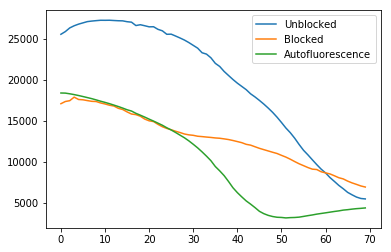

In [24]:
toplot="intensities vector"
conditioni=dfint["condition"].unique()
for condition in dfint["condition"].unique():
    
    df2plot=dfint[dfint["condition"]==condition]
    plt.plot(np.nanmean(df2plot[toplot].tolist(),axis=0))
    plt.legend(conditioni)